# Extractive Summarisation using LSA, LDA and Lunh's Heuristic

In [1]:
# Library Installations
!pip install nltk gensim sumy
!pip install datasets
!pip install scikit-learn
!pip install rouge
!pip install bert-score
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import LsiModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 19.3 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=b71359f669d163c4ba5504be59a7ffa72f5eeef15585a2bfac758b1d237c89a1
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=50615dd2ffa38ca690fdaad6cc6c662f0b46a540db81b7077f1776e2e42832b6
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('ccdv/pubmed-summarization', split="test")

# Shuffle the dataset with a seed and select the first 125 entries
test_data = dataset.shuffle(seed=42).select(range(125))



Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
test_data = pd.DataFrame(test_data)

In [4]:
test_data.head()

,article,abstract
0,the birth of a premature infant has long been ...,background : the purpose of this study was to ...
1,"de ridder , vanneste , and focquaert address c...",our ( 2014 ) model for the regulation of cogni...
2,it is not easy to define a good health care ...,"aim : to date , the available information rega..."
3,the prosite database uses two kinds of signatu...,the prosite database consists of a large colle...
4,although about two - thirds of patients with e...,"brivaracetam ( brv ) , a high - affinity synap..."


In [5]:
# Data Preproccesing

# Function to preprocess article text
def preprocess_article(article):
    # Convert to lowercase
    article = article.lower()

    # Remove non-alphanumeric characters and extra spaces
    article = re.sub(r'[^a-zA-Z0-9\s]', '', article)

    # Tokenize the article
    tokens = word_tokenize(article)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return lemmatized_tokens  # Return list of tokens

In [6]:
# Preprocess the article text in the DataFrame
test_data['preprocessed_article'] = test_data['article'].apply(preprocess_article)

# Convert list of lists of tokens to list of tokens
preprocessed_articles = test_data['preprocessed_article'].tolist()

# Latent Semantic Analysis (LSA)

In [7]:
from nltk.tokenize import sent_tokenize
# Create dictionary and corpus
dictionary = Dictionary(test_data['preprocessed_article'])
corpus = [dictionary.doc2bow(tokens) for tokens in test_data['preprocessed_article']]

# Build the LSA model
lsa_model = LsiModel(corpus, id2word=dictionary, num_topics=5)

def generate_summary_lsa(article, num_sentences=3):
    sentences = sent_tokenize(article)
    preprocessed_sentences = [preprocess_article(sentence) for sentence in sentences]
    bow_sentences = [dictionary.doc2bow(sentence) for sentence in preprocessed_sentences]

    # Use LSA model to get topics for each sentence
    lsa_scores = [lsa_model[bow] for bow in bow_sentences]

    # Sum topic contributions across sentences and get the score for each sentence
    sentence_scores = np.zeros(len(sentences))
    for i, scores in enumerate(lsa_scores):
        sentence_scores[i] = sum([score**2 for topic_id, score in scores])

    # Rank sentences by score
    ranked_sentences = np.argsort(sentence_scores)[::-1][:num_sentences]

    # Extract top sentences and sort by their original order in the article
    summary_sentences = [sentences[i] for i in ranked_sentences]
    summary = ' '.join(sorted(summary_sentences, key=lambda s: sentences.index(s)))

    return summary

# Apply to each article in the dataset
test_data['lsa_summary'] = test_data['article'].apply(generate_summary_lsa)


In [8]:
test_data.iloc[0,3]

"following the father 's inability to stay long and take care of the infant in ward 's environment , \n all mothers who were 18 years and older , could read and speak persian , had no infant admitted to the nicu , and with infants with the following criteria participated in this study : ( a ) gestational age of 26 - 34 weeks , ( b ) birth weight of less than 2500 g and appropriate for gestational age , ( c ) anticipated survival , ( d ) singleton birth , ( e ) no severe handicapping conditions , and ( f ) born at the study sites . the results of this study demonstrate the following : mothers in the cope program reported significantly less overall parental stress in the nicu than did mothers in the comparison group , the level of mothers anxiety reduced at the end of program ( after performing phase iv ) , and the mother 's participation in taking care of the infant did not have significant statistical differences between the two groups . therefore , the results of this study confirm th

# Latent Dirichlet Allocation (LDA)

In [9]:
from gensim.models import LdaModel
def train_lda_model(corpus, dictionary, num_topics=5):
    # Set training parameters.
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    return lda

# Assuming dictionary and corpus are already defined
lda_model = train_lda_model(corpus, dictionary, num_topics=5)

In [10]:
# Assuming preprocess_article is defined somewhere in your code and works correctly
# Define the summarization function
def lda_text_summary(model, dictionary, article, num_sentences=3):
    sentences = nltk.sent_tokenize(article)
    processed_sentences = [preprocess_article(sentence) for sentence in sentences]
    bow_sentences = [dictionary.doc2bow(sentence) for sentence in processed_sentences]

    # Calculate the most relevant sentences based on the LDA model
    sentence_scores = []
    for bow in bow_sentences:
        topic_scores = model.get_document_topics(bow, minimum_probability=0)
        weighted_score = sum([score for _, score in topic_scores])
        sentence_scores.append(weighted_score)

    # Select the sentences with the highest scores
    best_sentences = [sentence for _, sentence in sorted(zip(sentence_scores, sentences), reverse=True)[:num_sentences]]
    summary = ' '.join(best_sentences)
    return summary

# Now use the trained lda_model
test_data['lda_summary'] = test_data['article'].apply(lambda x: lda_text_summary(lda_model, dictionary, x))
print(test_data[['abstract', 'lda_summary']])


                                              abstract  \
0    background : the purpose of this study was to ...   
1    our ( 2014 ) model for the regulation of cogni...   
2    aim : to date , the available information rega...   
3    the prosite database consists of a large colle...   
4    brivaracetam ( brv ) , a high - affinity synap...   
..                                                 ...   
120  background : tympanosclerosis is a condition c...   
121  forskolin ( fsk ) induces activation of protei...   
122  an 810-nm diode laser was used to non - surgic...   
123  this study explored the extent to which nonpre...   
124  background : dysmenorrhea is one of the common...   

                                           lda_summary  
0    manipulation checks consisted of 10 true or fa...  
1    however , far from our proposals being  overly...  
2    the number of population served was a borderli...  
3    the new pattern is tested on a random database...  
4    in particular

In [11]:
test_data.iloc[0,4]

'manipulation checks consisted of 10 true or false questions that the mother answered immediately after each intervention phase to assure they processed the audiotaped information . mothers came to this place alone and one of the researchers gave instruments to them to complete . then , the mother answered the phase 2 manipulation check questions , and at the end , she received phase ii of activity workbook with specific instructions on how to complete .'

# Luhn's Heuristic

In [12]:
from collections import Counter

# Flatten the list of tokens across all articles to calculate frequency
all_tokens = [token for sublist in test_data['preprocessed_article'] for token in sublist]
word_frequencies = Counter(all_tokens)

# Determine the threshold for significant words (can be adjusted)
lower_threshold = np.percentile(list(word_frequencies.values()), 25)
upper_threshold = np.percentile(list(word_frequencies.values()), 75)


In [13]:
def luhn_summarization(text, tokens, lower_threshold, upper_threshold, num_sentences=3):
    significant_words = {word for word, freq in word_frequencies.items() if lower_threshold < freq < upper_threshold}

    # Split the text into sentences
    sentences = nltk.sent_tokenize(text)
    sentence_scores = []

    # Score each sentence
    for sentence in sentences:
        words = preprocess_article(sentence)
        score = sum(1 for word in words if word in significant_words)
        sentence_scores.append(score)

    # Sort sentences by score and select top sentences for summary
    top_sentence_indices = np.argsort(sentence_scores)[-num_sentences:]
    summary = ' '.join([sentences[index] for index in sorted(top_sentence_indices)])
    return summary

test_data['luhn_summary'] = test_data.apply(lambda row: luhn_summarization(row['article'], row['preprocessed_article'], lower_threshold, upper_threshold), axis=1)

In [14]:
print(test_data[['abstract', 'luhn_summary']])


                                              abstract  \
0    background : the purpose of this study was to ...   
1    our ( 2014 ) model for the regulation of cogni...   
2    aim : to date , the available information rega...   
3    the prosite database consists of a large colle...   
4    brivaracetam ( brv ) , a high - affinity synap...   
..                                                 ...   
120  background : tympanosclerosis is a condition c...   
121  forskolin ( fsk ) induces activation of protei...   
122  an 810-nm diode laser was used to non - surgic...   
123  this study explored the extent to which nonpre...   
124  background : dysmenorrhea is one of the common...   

                                          luhn_summary  
0    the content of the cope program and skill - bu...  
1    by proposing an ancillary list for specific co...  
2    about 37% of the physicians were specialized i...  
3    prosite matches on uniprot knowledgebase ( uni...  
4    at p28 and p2

In [15]:
test_data.iloc[0,5]

"the content of the cope program and skill - building activities is guided by self - regulation theory ( johnson , fieler , jones , wlasowicz , and mitchell , 1997 ) and control theory ( carver , 1979 ) ( as cited in melnyk et al . the content of the cope program and skill - building activities is guided by self - regulation theory ( johnson , fieler , jones , wlasowicz , and mitchell , 1997 ) and control theory ( carver , 1979 ) ( as cited in melnyk et al . in phase iii , \n supplementary information about the details of infant 's states and behavior , such as sleepiness , quiet alert state , or active alert state , and the best time to make communication with it is tendered ."

In [16]:
!pip install openpyxl

test_data.to_excel('test_data.xlsx', index=False)


# Choosing the best model

In [ ]:
!pip install bert-score

import pandas as pd
import numpy as np
from rouge import Rouge
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def calculate_cosine_similarity(reference, candidate):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([reference, candidate])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

def calculate_rouge_scores(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference, avg=True)
    return scores['rouge-1']['f'], scores['rouge-l']['f']  # ROUGE-N and ROUGE-L

def calculate_bert_score(reference, candidate):
    P, R, F1 = score([candidate], [reference], lang="en", rescale_with_baseline=True)
    return F1.mean().item()

def calculate_bleu_score(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    return sentence_bleu([reference_tokens], candidate_tokens)


In [ ]:
# takes a lot of time to run!
results = []

for index, row in test_data.iterrows():
    abstract = row['abstract']
    lsa_summary = row['lsa_summary']
    lda_summary = row['lda_summary']
    luhn_summary = row['luhn_summary']

    # Calculate scores for LSA
    lsa_cosine = calculate_cosine_similarity(abstract, lsa_summary)
    lsa_rouge1, lsa_rougel = calculate_rouge_scores(abstract, lsa_summary)
    lsa_bert = calculate_bert_score(abstract, lsa_summary)
    lsa_bleu = calculate_bleu_score(abstract, lsa_summary)

    # Calculate scores for LDA
    lda_cosine = calculate_cosine_similarity(abstract, lda_summary)
    lda_rouge1, lda_rougel = calculate_rouge_scores(abstract, lda_summary)
    lda_bert = calculate_bert_score(abstract, lda_summary)
    lda_bleu = calculate_bleu_score(abstract, lda_summary)

    # Calculate scores for Luhn's Heuristic
    luhn_cosine = calculate_cosine_similarity(abstract, luhn_summary)
    luhn_rouge1, luhn_rougel= calculate_rouge_scores(abstract, luhn_summary)
    luhn_bert = calculate_bert_score(abstract, luhn_summary)
    luhn_bleu = calculate_bleu_score(abstract, luhn_summary)

    # Store results
    results.append({
        'Article Index': index,
        'LSA Cosine': lsa_cosine,
        'LSA ROUGE-1': lsa_rouge1,
        'LSA ROUGE-L': lsa_rougel,
        'LSA BERTScore': lsa_bert,
        'LSA BLEU': lsa_bleu,
        'LDA Cosine': lda_cosine,
        'LDA ROUGE-1': lda_rouge1,
        'LDA ROUGE-L': lda_rougel,
        'LDA BERTScore': lda_bert,
        'LDA BLEU': lda_bleu,
        'Luhn Cosine': luhn_cosine,
        'Luhn ROUGE-1': luhn_rouge1,
        'Luhn ROUGE-L': luhn_rougel,
        'Luhn BERTScore': luhn_bert,
        'Luhn BLEU': luhn_bleu,
    })


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("Detailed Scores for All Articles:\n")
print(results_df)

Detailed Scores for All Articles:

     Article Index  LSA Cosine  LSA ROUGE-1  LSA ROUGE-L  LSA BERTScore  \
0                0    0.701010     0.364312     0.289963       0.014218   
1                1    0.529069     0.260000     0.220000       0.011957   
2                2    0.649546     0.476190     0.398268       0.159543   
3                3    0.330883     0.262500     0.262500      -0.071672   
4                4    0.651278     0.315615     0.289037      -0.022311   
..             ...         ...          ...          ...            ...   
120            120    0.681089     0.403756     0.384977       0.191419   
121            121    0.139200     0.253394     0.217195      -0.373794   
122            122    0.519141     0.330000     0.250000       0.031225   
123            123    0.405031     0.347305     0.287425       0.097458   
124            124    0.645810     0.360544     0.292517      -0.071697   

         LSA BLEU  LDA Cosine  LDA ROUGE-1  LDA ROUGE-L  LDA BER

In [ ]:
summary_stats = results_df.describe().loc[['mean']]
print("Summary Statistics for All Articles:\n")
print(summary_stats)


Summary Statistics for All Articles:

      Article Index  LSA Cosine  LSA ROUGE-1  LSA ROUGE-L  LSA BERTScore  \
mean           62.0    0.440894     0.309765     0.271506      -0.028313   

      LSA BLEU  LDA Cosine  LDA ROUGE-1  LDA ROUGE-L  LDA BERTScore  LDA BLEU  \
mean  0.049162    0.383422     0.276174     0.244998      -0.030446  0.024061   

      Luhn Cosine  Luhn ROUGE-1  Luhn ROUGE-L  Luhn BERTScore  Luhn BLEU  
mean     0.356192      0.250208       0.21822       -0.118994   0.026078  


To conclude, **LSA** consistently outperforms other methods (LDA and Luhn) on an average. It is the most effective method among the three for maintaining both the structure and content of the original texts.



# Fine Tuning - LSA Model

Coherence Scores: [0.411523784794991, 0.5566860886753293, 0.48876866934941804, 0.5706207589665996, 0.43944995535625697, 0.4714028889574841, 0.48232778985341035, 0.4727775338870868]


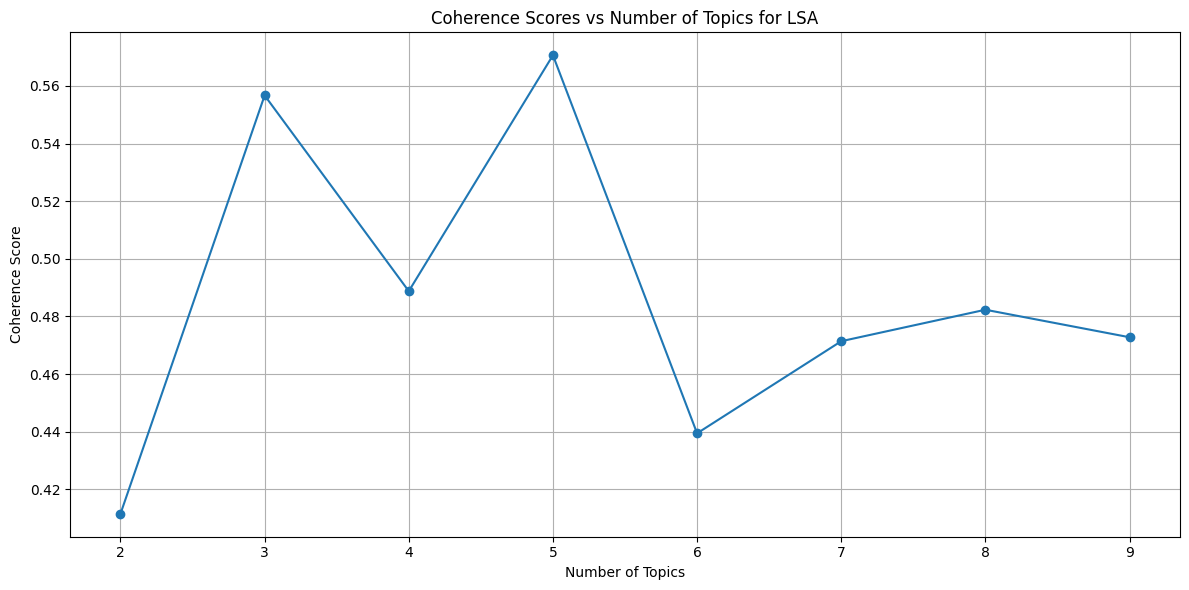

In [ ]:
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary

texts = test_data['preprocessed_article']
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Range of topics to evaluate
topic_range = range(2, 10)  # Adjust as needed

# List to store coherence scores
coherence_scores = []

for num_topics in topic_range:
    # Build the LSA model for the current number of topics
    lsa_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_seed=42)
    # Initialize CoherenceModel after training the LSA model
    coherence_model_lsa = CoherenceModel(model=lsa_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lsa)

# Print the scores to check
print('Coherence Scores:', coherence_scores)


import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.title("Coherence Scores vs Number of Topics for LSA")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid(True)
plt.tight_layout()
plt.show()


The chosen number of topic is 5 and therefore no other changes are required as the coherence score is higher compared to the others.

In [ ]:
from rouge import Rouge
import pandas as pd
from bert_score import score
import numpy as np

def calculate_metrics(df):
    # BERTScore calculation
    P, R, F1 = score(df['lsa_summary'].tolist(), df['abstract'].tolist(), lang='en', rescale_with_baseline=True)

    # Average BERTScore
    bert_scores = {
        'precision': P.mean().item(),
        'recall': R.mean().item(),
        'f1': F1.mean().item()
    }

    return bert_scores

# Call the function with your DataFrame
bert_scores = calculate_metrics(test_data)

def calculate_rouge_metrics(df):
    # Initialize ROUGE
    rouge = Rouge()
    scores = rouge.get_scores(df['lsa_summary'], df['abstract'], avg=False)

    # Initialize lists to hold the precision, recall, and f1 scores for each ROUGE metric
    precision_rouge1 = []
    recall_rouge1 = []
    f1_rouge1 = []

    precision_rouge2 = []
    recall_rouge2 = []
    f1_rouge2 = []

    precision_rougeL = []
    recall_rougeL = []
    f1_rougeL = []

    # Extract scores for each summary
    for score in scores:
        # ROUGE-1
        precision_rouge1.append(score['rouge-1']['p'])
        recall_rouge1.append(score['rouge-1']['r'])
        f1_rouge1.append(score['rouge-1']['f'])

        # ROUGE-2
        precision_rouge2.append(score['rouge-2']['p'])
        recall_rouge2.append(score['rouge-2']['r'])
        f1_rouge2.append(score['rouge-2']['f'])

        # ROUGE-L
        precision_rougeL.append(score['rouge-l']['p'])
        recall_rougeL.append(score['rouge-l']['r'])
        f1_rougeL.append(score['rouge-l']['f'])

    # Create a DataFrame to store averages of each metric
    results_df = pd.DataFrame({
        'ROUGE-1': [np.mean(precision_rouge1), np.mean(recall_rouge1), np.mean(f1_rouge1)],
        'ROUGE-2': [np.mean(precision_rouge2), np.mean(recall_rouge2), np.mean(f1_rouge2)],
        'ROUGE-L': [np.mean(precision_rougeL), np.mean(recall_rougeL), np.mean(f1_rougeL)]
    }, index=['Precision', 'Recall', 'F1'])

    return results_df

# Call the function with your DataFrame
rouge_results = calculate_rouge_metrics(test_data)
print("\nROUGE Metrics:")
print(rouge_results)
print("\nBERT Scores:\n", bert_scores)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ROUGE Metrics:
            ROUGE-1   ROUGE-2   ROUGE-L
Precision  0.359091  0.117349  0.316024
Recall     0.302652  0.091154  0.263516
F1         0.309765  0.095297  0.271506

BERT Scores:
 {'precision': -0.024477779865264893, 'recall': -0.03264506906270981, 'f1': -0.02841135859489441}


In [ ]:
# Scores for LDA
def calculate_metrics(df):
    # BERTScore calculation
    P, R, F1 = score(df['lda_summary'].tolist(), df['abstract'].tolist(), lang='en', rescale_with_baseline=True)

    # Average BERTScore
    bert_scores = {
        'precision': P.mean().item(),
        'recall': R.mean().item(),
        'f1': F1.mean().item()
    }

    return bert_scores

# Call the function with your DataFrame
bert_scores = calculate_metrics(test_data)

def calculate_rouge_metrics(df):
    # Initialize ROUGE
    rouge = Rouge()
    scores = rouge.get_scores(df['lda_summary'], df['abstract'], avg=False)

    # Initialize lists to hold the precision, recall, and f1 scores for each ROUGE metric
    precision_rouge1 = []
    recall_rouge1 = []
    f1_rouge1 = []

    precision_rouge2 = []
    recall_rouge2 = []
    f1_rouge2 = []

    precision_rougeL = []
    recall_rougeL = []
    f1_rougeL = []

    # Extract scores for each summary
    for score in scores:
        # ROUGE-1
        precision_rouge1.append(score['rouge-1']['p'])
        recall_rouge1.append(score['rouge-1']['r'])
        f1_rouge1.append(score['rouge-1']['f'])

        # ROUGE-2
        precision_rouge2.append(score['rouge-2']['p'])
        recall_rouge2.append(score['rouge-2']['r'])
        f1_rouge2.append(score['rouge-2']['f'])

        # ROUGE-L
        precision_rougeL.append(score['rouge-l']['p'])
        recall_rougeL.append(score['rouge-l']['r'])
        f1_rougeL.append(score['rouge-l']['f'])

    # Create a DataFrame to store averages of each metric
    results_df = pd.DataFrame({
        'ROUGE-1': [np.mean(precision_rouge1), np.mean(recall_rouge1), np.mean(f1_rouge1)],
        'ROUGE-2': [np.mean(precision_rouge2), np.mean(recall_rouge2), np.mean(f1_rouge2)],
        'ROUGE-L': [np.mean(precision_rougeL), np.mean(recall_rougeL), np.mean(f1_rougeL)]
    }, index=['Precision', 'Recall', 'F1'])

    return results_df

# Call the function with your DataFrame
rouge_results = calculate_rouge_metrics(test_data)
print("\nROUGE Metrics:")
print(rouge_results)
print("\nBERT Scores:\n", bert_scores)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ROUGE Metrics:
            ROUGE-1   ROUGE-2   ROUGE-L
Precision  0.381627  0.116697  0.338734
Recall     0.228340  0.057272  0.201467
F1         0.273868  0.072710  0.242376

BERT Scores:
 {'precision': 0.037205468863248825, 'recall': -0.07751590013504028, 'f1': -0.020371638238430023}


In [ ]:
# Scores for Luhn
def calculate_metrics(df):
    # BERTScore calculation
    P, R, F1 = score(df['luhn_summary'].tolist(), df['abstract'].tolist(), lang='en', rescale_with_baseline=True)

    # Average BERTScore
    bert_scores = {
        'precision': P.mean().item(),
        'recall': R.mean().item(),
        'f1': F1.mean().item()
    }

    return bert_scores

# Call the function with your DataFrame
bert_scores = calculate_metrics(test_data)

def calculate_rouge_metrics(df):
    # Initialize ROUGE
    rouge = Rouge()
    scores = rouge.get_scores(df['luhn_summary'], df['abstract'], avg=False)

    # Initialize lists to hold the precision, recall, and f1 scores for each ROUGE metric
    precision_rouge1 = []
    recall_rouge1 = []
    f1_rouge1 = []

    precision_rouge2 = []
    recall_rouge2 = []
    f1_rouge2 = []

    precision_rougeL = []
    recall_rougeL = []
    f1_rougeL = []

    # Extract scores for each summary
    for score in scores:
        # ROUGE-1
        precision_rouge1.append(score['rouge-1']['p'])
        recall_rouge1.append(score['rouge-1']['r'])
        f1_rouge1.append(score['rouge-1']['f'])

        # ROUGE-2
        precision_rouge2.append(score['rouge-2']['p'])
        recall_rouge2.append(score['rouge-2']['r'])
        f1_rouge2.append(score['rouge-2']['f'])

        # ROUGE-L
        precision_rougeL.append(score['rouge-l']['p'])
        recall_rougeL.append(score['rouge-l']['r'])
        f1_rougeL.append(score['rouge-l']['f'])

    # Create a DataFrame to store averages of each metric
    results_df = pd.DataFrame({
        'ROUGE-1': [np.mean(precision_rouge1), np.mean(recall_rouge1), np.mean(f1_rouge1)],
        'ROUGE-2': [np.mean(precision_rouge2), np.mean(recall_rouge2), np.mean(f1_rouge2)],
        'ROUGE-L': [np.mean(precision_rougeL), np.mean(recall_rougeL), np.mean(f1_rougeL)]
    }, index=['Precision', 'Recall', 'F1'])

    return results_df

# Call the function with your DataFrame
rouge_results = calculate_rouge_metrics(test_data)
print("\nROUGE Metrics:")
print(rouge_results)
print("\nBERT Scores:\n", bert_scores)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ROUGE Metrics:
            ROUGE-1   ROUGE-2   ROUGE-L
Precision  0.292755  0.079001  0.256970
Recall     0.245720  0.059720  0.213919
F1         0.252563  0.062733  0.220545

BERT Scores:
 {'precision': -0.1485789269208908, 'recall': -0.08601028472185135, 'f1': -0.11702752113342285}


In the medical field, the accuracy and reliability of information are paramount. Extractive summarization systems are often used to help professionals quickly grasp key information without sifting through entire documents.

Given the critical nature of medical summaries, where retaining comprehensive, accurate information is paramount, **LSA** would likely be the best choice among the three. It balances detail retention with accuracy, ensuring a more complete and reliable summary, essential in medical settings where the integrity of information is crucial.

However, the metrics suggest that the current LSA-based system might not yet be reliable enough for clinical or research purposes where missing or misrepresented information could lead to incorrect decisions or understandings.